In [61]:
import os
import warnings
from nilearn import datasets
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [62]:
data_dir = os.path.join('data')
haxby_dataset = datasets.fetch_haxby(subjects=[1, 2, 3, 4, 5, 6], fetch_stimuli=True, data_dir=data_dir)
func_file = haxby_dataset.func[0]
print(func_file)

data\haxby2001\subj1\bold.nii.gz


In [35]:
# mask the data
from nilearn.input_data import NiftiMasker
mask_filename = haxby_dataset.mask_vt[0]
masker = NiftiMasker(mask_img=mask_filename, standardize=True, detrend=True)
X = masker.fit_transform(func_file)

In [37]:
# cognitive annotations
import pandas as pd
behavioral = pd.read_csv(haxby_dataset.session_target[0], delimiter=' ')
labels = behavioral['labels']

In [38]:
categories = labels.unique()
print(categories)
print(labels.shape)
print(X.shape)
class_dict = {'rest': 0, 'bottle': 1, 'cat': 2, 'chair': 3, 'face': 4, 'house': 5, 'scissors': 6, 'scrambledpix': 7, 'shoe': 8}

['rest' 'scissors' 'face' 'cat' 'shoe' 'house' 'scrambledpix' 'bottle'
 'chair']
(1452,)
(1452, 577)


In [41]:
y = np.array([class_dict[label] for label in labels.values])

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)   

### Datasets

In [44]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [53]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

### MLP model

In [66]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.selu1 = nn.SELU()
        self.selu2 = nn.SELU()

    def forward(self, x):
        x = self.selu1(self.fc1(x))
        x = self.selu2(self.fc2(x))
        x = self.fc3(x)
        return x

### Training and evaluating MLP

In [67]:
input_size = 577
hidden_size = 256
output_size = 9
lr = 1e-3
num_epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MLP(input_size, hidden_size, output_size).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
print(device)

cpu


Epoch [1/20], Train Loss: 0.9368, Train Accuracy: 0.6701, Train F1-score: 0.6706
Epoch [1/20], Test Accuracy: 0.7801, Test F1-score: 0.7716
Epoch [2/20], Train Loss: 0.3583, Train Accuracy: 0.8975, Train F1-score: 0.8975
Epoch [2/20], Test Accuracy: 0.8694, Test F1-score: 0.8677
Epoch [3/20], Train Loss: 0.2765, Train Accuracy: 0.9096, Train F1-score: 0.9098
Epoch [3/20], Test Accuracy: 0.8351, Test F1-score: 0.8333
Epoch [4/20], Train Loss: 0.1869, Train Accuracy: 0.9406, Train F1-score: 0.9409
Epoch [4/20], Test Accuracy: 0.9175, Test F1-score: 0.9178
Epoch [5/20], Train Loss: 0.0753, Train Accuracy: 0.9733, Train F1-score: 0.9733
Epoch [5/20], Test Accuracy: 0.8763, Test F1-score: 0.8766
Epoch [6/20], Train Loss: 0.0606, Train Accuracy: 0.9836, Train F1-score: 0.9837
Epoch [6/20], Test Accuracy: 0.8625, Test F1-score: 0.8640
Epoch [7/20], Train Loss: 0.0580, Train Accuracy: 0.9871, Train F1-score: 0.9871
Epoch [7/20], Test Accuracy: 0.9175, Test F1-score: 0.9167
Epoch [8/20], Train 

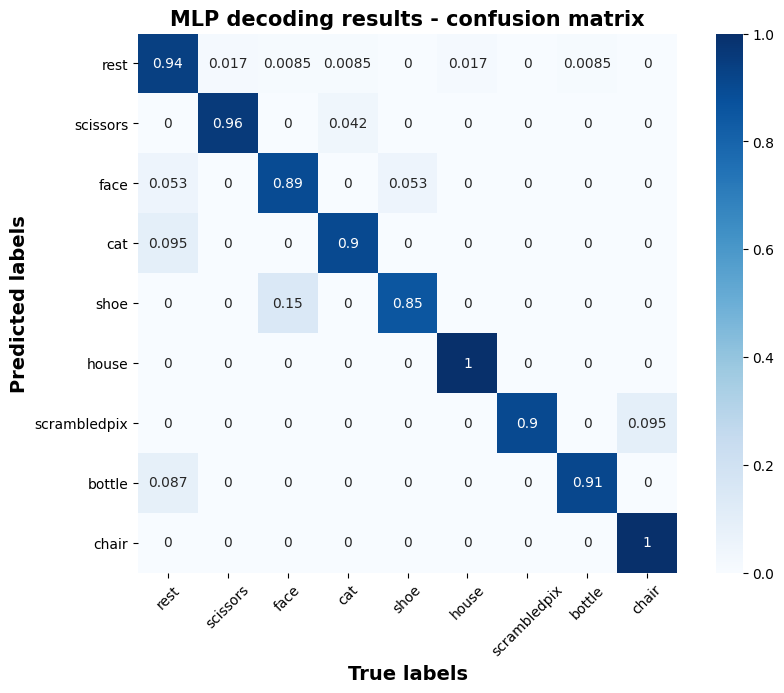

Training finished.


In [69]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    all_train_preds = []
    all_train_labels = []

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        all_train_preds.extend(predicted.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())

    train_loss = running_loss / len(train_dataset)
    train_accuracy = correct_train / total_train
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train F1-score: {train_f1:.4f}')

    model.eval()
    correct_test = 0
    total_test = 0
    all_test_preds = []
    all_test_labels = []
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            all_test_preds.extend(predicted.cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())

    test_accuracy = correct_test / total_test
    test_f1 = f1_score(all_test_labels, all_test_preds, average='weighted')

    print(f'Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {test_accuracy:.4f}, Test F1-score: {test_f1:.4f}')

model_conf_matrix = confusion_matrix(all_test_labels, all_test_preds)
model_conf_matrix = model_conf_matrix.astype('float') / model_conf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(model_conf_matrix, index=categories, columns=categories)

plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, cmap='Blues', square=True)
plt.xticks(rotation=45)
plt.title('MLP decoding results - confusion matrix', fontsize=15, fontweight='bold')
plt.xlabel("True labels", fontsize=14, fontweight='bold')
plt.ylabel("Predicted labels", fontsize=14, fontweight='bold')
plt.show()

print("Training finished.")